In [61]:
library(tidyverse)

# Here we train our final model using the parameters from before.
setwd("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/")
best_params <- read.csv("../outputs/B_outputs/B11_lgb_grid_kyoto_best_params.csv")
best_params


boostings,learning_rates,max_bins,num_leaves,max_depth,iteration,binary_logloss,auc,binary_error
<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
gbdt,0.1,255,10,10,53,0.294,0.936,0.123
gbdt,0.1,255,10,10,53,0.294,0.936,0.123
gbdt,0.1,15,10,10,47,0.297,0.932,0.121


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 146  19
         1  46  94
                                          
               Accuracy : 0.7869          
                 95% CI : (0.7366, 0.8315)
    No Information Rate : 0.6295          
    P-Value [Acc > NIR] : 2.285e-09       
                                          
                  Kappa : 0.5645          
                                          
 Mcnemar's Test P-Value : 0.00126         
                                          
            Sensitivity : 0.7604          
            Specificity : 0.8319          
         Pos Pred Value : 0.8848          
         Neg Pred Value : 0.6714          
             Prevalence : 0.6295          
         Detection Rate : 0.4787          
   Detection Prevalence : 0.5410          
      Balanced Accuracy : 0.7961          
                                          
       'Positive' Class : 0               
                              

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
Ca_cumsum,0.483416867,0.357057168,0.29107981
day,0.325061928,0.211503872,0.20344288
month,0.069290495,0.049130210,0.06885759
Cd_cumsum,0.028988916,0.093286828,0.10641628
daily_Ca,0.021977799,0.060844064,0.08763693
lat,0.020574263,0.047770717,0.05320814
tmax,0.020013988,0.055740916,0.05790297
alt,0.011283375,0.039112358,0.03912363
tmin,0.007646793,0.069344263,0.04538341


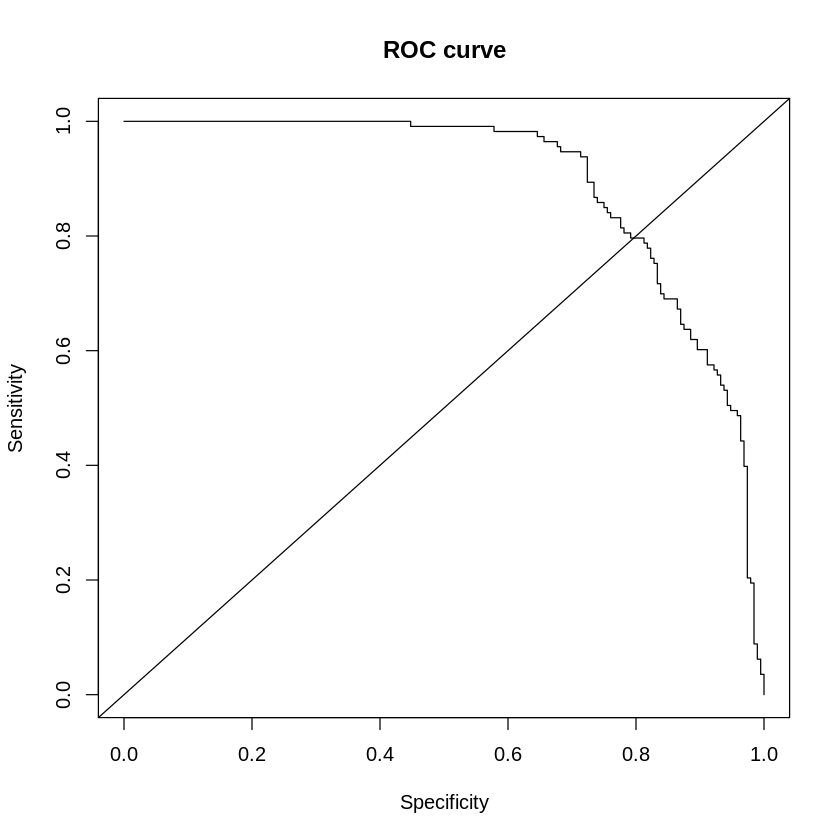

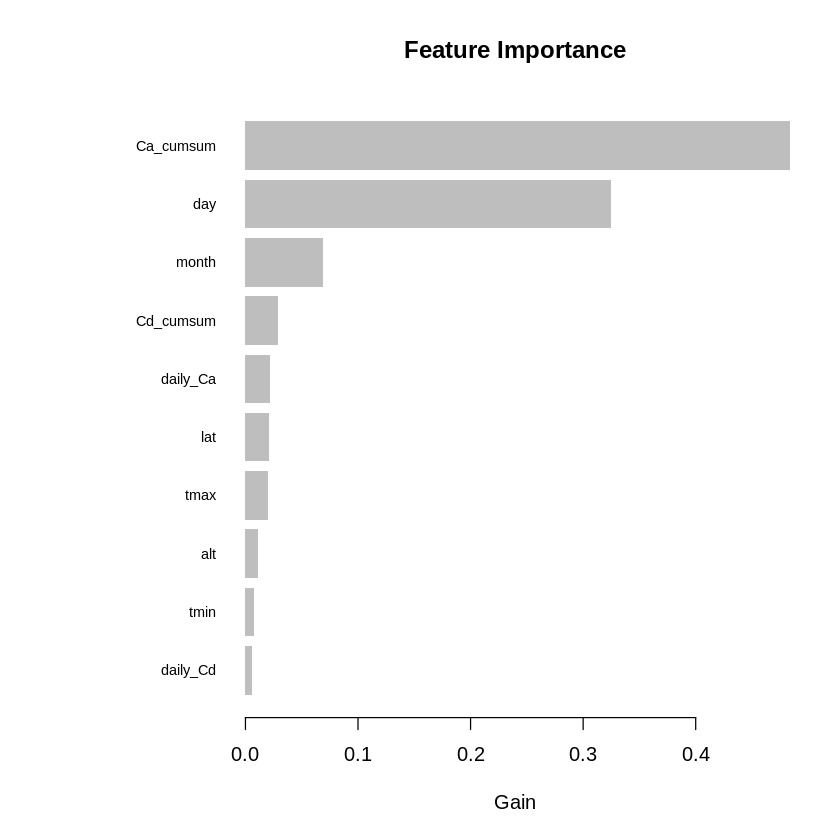

In [63]:
# Run below codes after running the above
library(tidyverse)
library(lightgbm)

lgb_load <- readRDS.lgb.Booster('../outputs/B_outputs/B21_lgb_final.rds')
test_set <- read.csv("../outputs/B_outputs/B11_japan_test.csv")
source("/home/joosungm/projects/def-lelliott/joosungm/projects/peak-bloom-prediction/code/F01_functions.r")
# feature_names <- c("tmax", "tmin", "prcp", "month", "day", "daily_Ca", "daily_Cd", "Cd_cumsum", "Ca_cumsum", "lat", "long", "alt")
# target_col <- "is_bloom"

pred <- predict(lgb_load, as.matrix(test_set[, feature_names]))
test_set$predicted <- ifelse(pred > 0.5, 1, 0)

# Confusion matrix
library(caret)
confusionMatrix(factor(test_set$predicted), factor(test_set$is_bloom))

# ROC curve
library(ROCR)
roc_pred <- prediction(pred, test_set$is_bloom)
roc <- performance(roc_pred, "sens", "spec")
plot(roc, main="ROC curve")
abline(a=0, b=1)

# Feature importance
lgb_imp <- lgb.importance(lgb_load)
lgb_imp
lgb.plot.importance(lgb_imp, top_n = 10L, measure = "Gain")

In [64]:
cherry_main_data <- read.csv("../outputs/A_outputs/A11_kyoto_out.csv") %>%
    filter(year %in% 2012:2023) %>%
    dplyr::select(all_of(c("bloom_date", "lat", "long", "alt")))
# head(cherry_main_data)

gdd_data <- read.csv("../outputs/A_outputs/A41_gdd_kyoto.csv") %>%
    filter(year %in% 2012:2023) %>%
    filter(name == "KYOTO") %>%
    mutate(lat = unique(cherry_main_data$lat)) %>%
    mutate(long = unique(cherry_main_data$long)) %>%
    mutate(alt = unique(cherry_main_data$alt))
# head(gdd_data)
# dim(gdd_data)

write.csv("../outputs/B_outputs/B21_kyoto_gdd_test.csv", row.names = FALSE)


"x"
"../outputs/B_outputs/B21_kyoto_gdd_test.csv"


In [79]:
# Make predictions
kyoto_gdd <- gdd_data
kyoto_years <- unique(kyoto_gdd$year)
error_cols <- c("year", "date", "pred_date", "diff")
error_table <- data.frame(matrix(nrow = length(kyoto_years), ncol = length(error_cols), dimnames = list(NULL, error_cols)))

p_thresh <- 0.70

for (y in seq_len(length(kyoto_years))) {
    
    yr <- kyoto_years[y]
    
    temp_data <- kyoto_gdd[kyoto_gdd$year == yr, ]
    pred <- predict(lgb_load, as.matrix(temp_data[, feature_names]))
    temp_data$pred_prob <- pred
    temp_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)

    actual_bloom_idx <- which(temp_data$is_bloom == 1)
    actual_bloom_date <- temp_data[actual_bloom_idx, "date"]
    if (yr == 2022) {
        actual_bloom_date <- "2022-04-01"
    }
    
    pred_blooms <- which(temp_data$pred_bin == 1)
    # pred_bloom_start_idx <- pred_blooms[1]
    pred_bloom_start_idx <- which(temp_data$pred_prob == max(temp_data$pred_prob))[1] # take the highest probability day as the blooming date.
    pred_bloom_start_date <- temp_data[pred_bloom_start_idx, "date"]
    
    if (is.na(pred_bloom_start_date)) {
        pred_bloom_start_date <- temp_data[which(temp_data$pred_prob == max(temp_data$pred_prob))[1], "date"]
    }

    temp_diff <- as.numeric(as.Date(pred_bloom_start_date)) - as.numeric(as.Date(actual_bloom_date))
    error_table[y, ] <- c(yr, actual_bloom_date, pred_bloom_start_date, temp_diff)
}
error_table
mean(abs(as.numeric(error_table$diff)), na.rm = TRUE)

year,date,pred_date,diff
<chr>,<chr>,<chr>,<chr>
2012,2012-04-09,2012-04-05,-4
2013,2013-03-30,2013-04-02,3
2014,2014-04-02,2014-04-06,4
2015,2015-04-01,2015-04-04,3
2016,2016-04-02,2016-04-02,0
2017,2017-04-07,2017-04-06,-1
2018,2018-03-28,2018-04-02,5
2019,2019-04-06,2019-04-06,0
2020,2020-03-30,2020-03-31,1


[1] 3.636364

,year,date,bloom_doy,cat
,<chr>,<chr>,<dbl>,<chr>
1,2012,2012-04-09,99,actual
2,2013,2013-03-30,88,actual
3,2014,2014-04-02,91,actual
4,2015,2015-04-01,90,actual
5,2016,2016-04-02,92,actual
6,2017,2017-04-07,96,actual


Warning message:
“Removed 1 rows containing missing values (geom_point).”


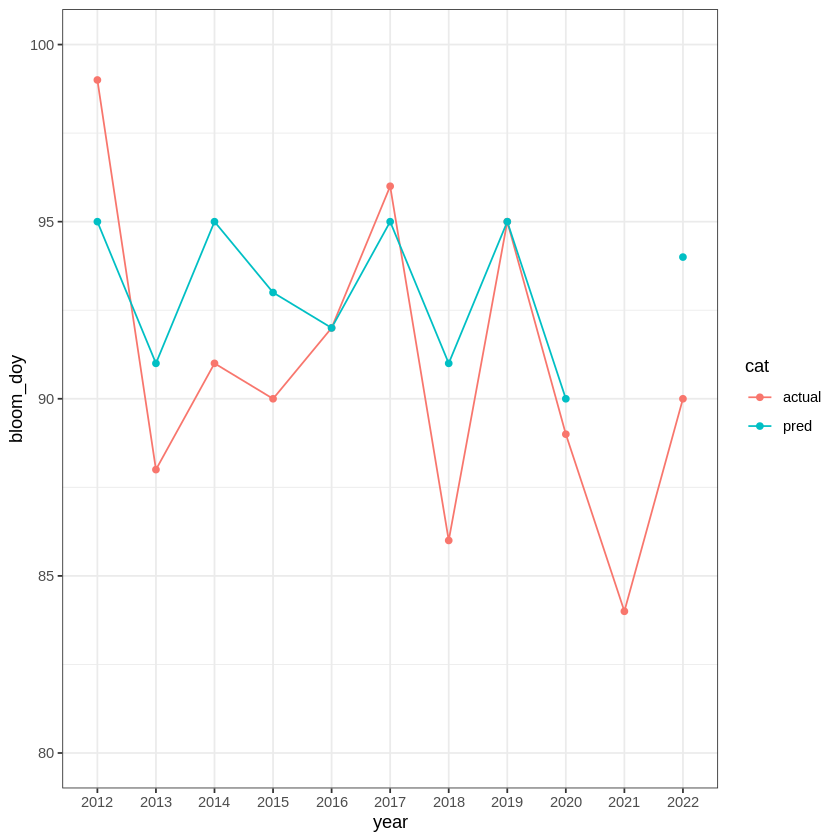

In [67]:
# plot bloom_doys

error_table2 <- error_table
error_table2$first_day <- as.Date(paste0(error_table2$year, "-01-01"))
error_table2$actual_bloom_doy <- as.numeric(as.Date(error_table2$date)) - as.numeric(as.Date(error_table2$first_day))
error_table2$pred_bloom_doy <- as.numeric(as.Date(error_table2$pred_date)) - as.numeric(as.Date(error_table2$first_day))
# head(error_table2)

error_table2_actual <- error_table2 %>% 
    select(year, date, actual_bloom_doy) %>% mutate(cat = "actual") %>% 
    rename_with(~"bloom_doy", actual_bloom_doy)

error_table2_pred <- error_table2 %>% select(year, pred_date, pred_bloom_doy) %>% mutate(cat = "pred") %>% 
    rename_with(~"bloom_doy", pred_bloom_doy) %>% 
    rename_with(~"date", pred_date)

error_table3 <- rbind(error_table2_actual, error_table2_pred)
head(error_table3)

col_groups <- c("tomato", "dark green")

p <- ggplot(data = error_table3, mapping = aes(x = year, y = bloom_doy, group = cat, color = cat))
p <- p + geom_line()
p <- p + geom_point()
p <- p + theme_bw()
p <- p + ylim(c(80, 100))
p

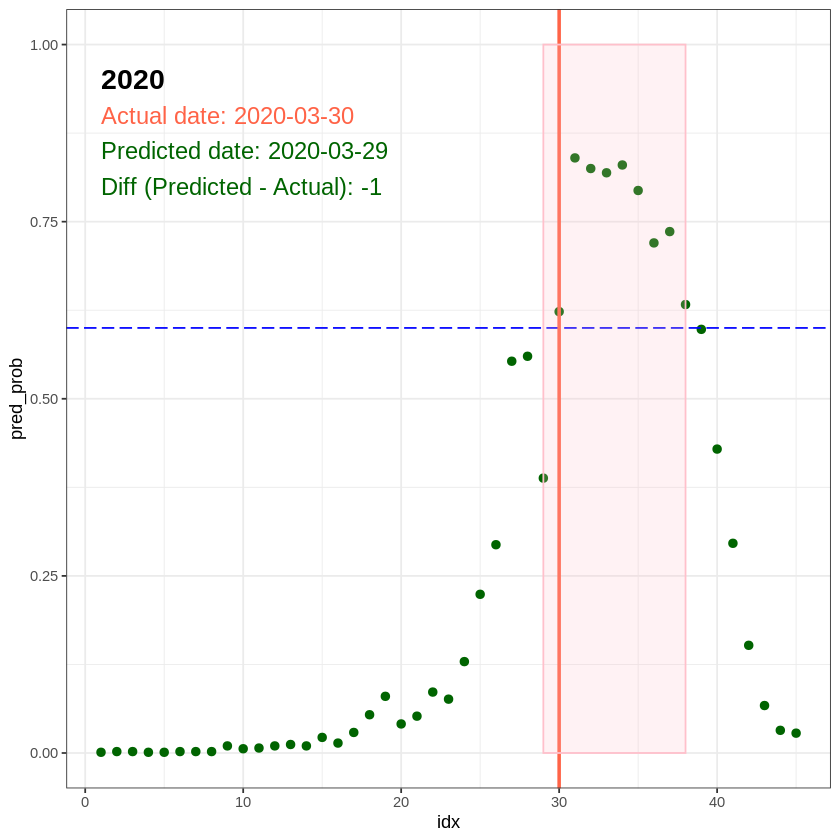

In [60]:
# for one year

yr = 2020
p_thresh <- 0.6
year_data <- gdd_data %>% filter(year == yr & name == "KYOTO") %>%
    dplyr::select(all_of(c("date", feature_names, target_col)))
# head(year_data[year_data$is_bloom == 1, ])
# dim(year_data)

# Make prediction on this data

pred <- predict(lgb_load, as.matrix(year_data[, feature_names]))
year_data$pred_prob <- round(pred, 3) 
year_data$pred_bin <- ifelse(pred > p_thresh, 1, 0)
year_data$idx <- seq_len(nrow(year_data))
# year_data[, c("date", "is_bloom", "pred_prob", "pred_bin")]

actual_bloom_day_idx <- which(year_data$is_bloom == 1)
actual_bloom_day <- year_data[actual_bloom_day_idx, "date"]

predicted_bloom_days <- which(year_data$pred_bin == 1)
# predicted_bloom_day_idx <-predicted_bloom_days[1]
predicted_bloom_day_idx <- which(year_data$pred_prob == max(year_data$pred_prob))[1] -2 # take the highest probability day as the blooming date.
predicted_bloom_day <- year_data[predicted_bloom_day_idx, "date"]
predicted_bloom_end_idx <- predicted_bloom_days[length(predicted_bloom_days)]

diff_days <- as.numeric(as.Date(predicted_bloom_day)) - as.numeric(as.Date(actual_bloom_day))

p <- ggplot(data = year_data)
p <- p + geom_point(aes(x = idx, y = pred_prob), color = "dark green", lwd = 2)
p <- p + ylim(c(0, 1))
p <- p + geom_hline(yintercept = p_thresh, color = "blue", linetype = "longdash")
p <- p + geom_vline(xintercept = actual_bloom_day_idx, color = "tomato", linetype = "solid", lwd = 1)
p <- p + theme_bw()
p <- p + annotate("text", x = 1, y = 0.95, label = yr, fontface = "bold", color = "black", size = 6, hjust = 0)
p <- p + annotate("text", x = 1, y = 0.90, label = paste0("Actual date: ", actual_bloom_day), size = 5, color = "tomato", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.85, label = paste0("Predicted date: ", predicted_bloom_day), size = 5, color = "dark green", hjust = 0)
p <- p + annotate("text", x = 1, y = 0.80, label = paste0("Diff (Predicted - Actual): ", diff_days), color = ifelse(diff_days > 0, "tomato", "dark green"), size = 5, hjust = 0)
p <- p + annotate("rect", xmin = predicted_bloom_day_idx, xmax = predicted_bloom_end_idx
            , ymin = 0, ymax = 1, alpha = 0.2, color = "pink", fill = "pink")
p

In [43]:
year_data$Ca_cumsum

[1]  38.40  41.10  44.45  47.15  52.15  53.30  54.25  57.25  61.00  66.05
[11]  72.30  74.25  85.75  95.75 102.35 110.00 115.35 118.90 121.10 123.65
[21] 127.35 129.30 132.30 136.65 143.25 149.40 157.05 160.75 165.75 174.55
[31] 178.65 181.45 187.10 190.90 196.60 204.00 210.80 214.75 225.35 235.50
[41] 248.20 261.35 275.65 293.15

In [107]:
diff_days <- as.numeric(as.Date(actual_bloom_day)) - as.numeric(as.Date(predicted_bloom_day))
diff_days

[1] 2

In [39]:
## Final prediction

# download weather forecasts for 2023-03-01 - 2023-04-15
# https://www.accuweather.com/en/jp/kyoto-shi/224436/march-weather/224436?year=2023

data_2023 <- read.csv("../data/2023-mar-apr-kyoto.csv")
# head(data_2023)

# compute daily_Ca, daily_Cd, Ca_cumsum, Cd_cumsum
data_2023$year <- 2023
data_2023$daily_Cd <- apply(data_2023, MARGIN = 1, FUN = F01_chill_days)[1, ]
data_2023$daily_Ca <- apply(data_2023, MARGIN = 1, FUN = F01_chill_days)[2, ]
data_2023$Cd_cumsum <- cumsum(data_2023$daily_Cd)
data_2023$Ca_cumsum <- cumsum(data_2023$daily_Ca)
data_2023$month <- as.integer(strftime(data_2023$date, "%m"))
data_2023$day <- as.integer(strftime(data_2023$date, "%d"))

kyoto <- read.csv("../data/kyoto.csv")
data_2023$lat <- unique(kyoto$lat)
data_2023$long <- unique(kyoto$long)
data_2023$alt <- unique(kyoto$alt)

head(data_2023)

,date,tmax,tmin,year,daily_Cd,daily_Ca,Cd_cumsum,Ca_cumsum,month,day,lat,long,alt
,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>
1,2023-03-01,8,-1,2023,-3.055556,0.5,-3.055556,0.5,3,1,35.01198,135.6761,44
2,2023-03-02,9,1,2023,-3.000000,1.0,-6.055556,1.5,3,2,35.01198,135.6761,44
3,2023-03-03,13,0,2023,-3.500000,3.0,-9.555556,4.5,3,3,35.01198,135.6761,44
4,2023-03-04,8,0,2023,-3.500000,0.5,-13.055556,5.0,3,4,35.01198,135.6761,44
5,2023-03-05,9,1,2023,-3.000000,1.0,-16.055556,6.0,3,5,35.01198,135.6761,44
6,2023-03-06,10,3,2023,-2.000000,1.5,-18.055556,7.5,3,6,35.01198,135.6761,44


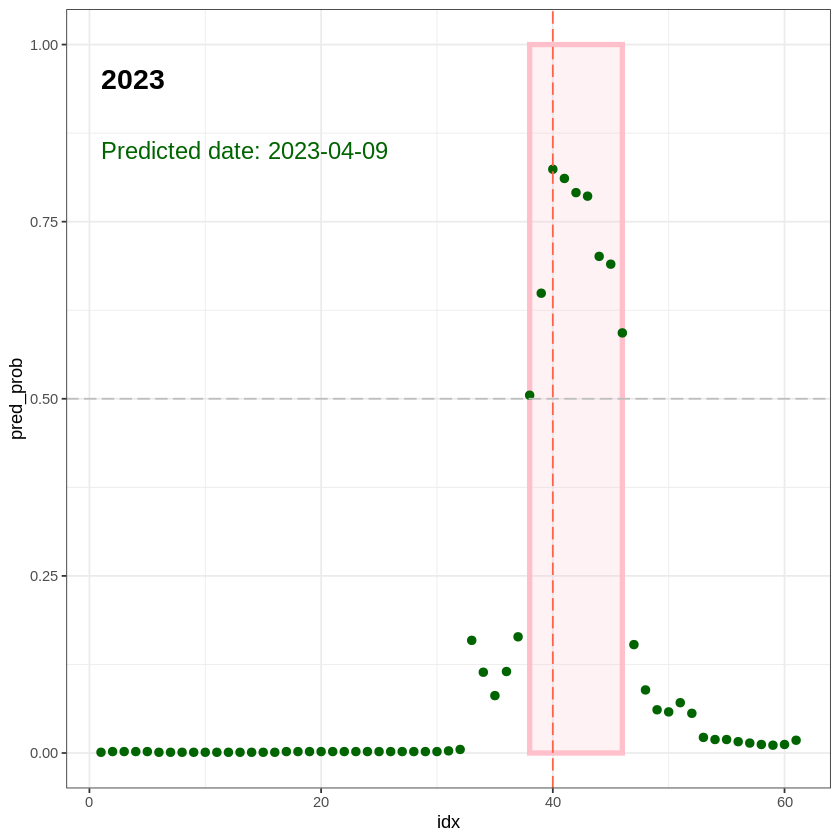

In [84]:

p_thresh <- 0.5
pred <- predict(lgb_load, as.matrix(data_2023[, feature_names]))
data_2023$pred_prob <- round(pred, 3) 
data_2023$idx <- seq_len(nrow(data_2023))

predicted_bloom_days <- which(data_2023$pred_prob > p_thresh)
predicted_bloom_start_idx <- predicted_bloom_days[1]
predicted_bloom_end_idx <- predicted_bloom_days[length(predicted_bloom_days)]

predicted_bloom_start_date <- data_2023[predicted_bloom_start_idx, "date"]
predicted_bloom_end_date <- data_2023[predicted_bloom_end_idx, "date"]

peak_bloom_day_idx <- which(data_2023$pred_prob == max(data_2023$pred_prob))[1] # take the highest probability day as the blooming date.
peak_bloom_date <- data_2023[peak_bloom_day_idx, "date"]


p <- ggplot(data = data_2023)
p <- p + annotate("rect", xmin = predicted_bloom_start_idx, xmax = predicted_bloom_end_idx
            , ymin = 0, ymax = 1, alpha = 0.2, color = "pink", fill = "pink", lwd = 1.5)
p <- p + geom_point(aes(x = idx, y = pred_prob), color = "dark green", lwd = 2)
p <- p + ylim(c(0, 1))
p <- p + geom_vline(xintercept = peak_bloom_day_idx, color = "tomato", linetype = "longdash")
p <- p + geom_hline(yintercept = p_thresh, color = "grey", linetype = "longdash")
p <- p + theme_bw()
p <- p + annotate("text", x = 1, y = 0.95, label = "2023", fontface = "bold", color = "black", size = 6, hjust = 0)
p <- p + annotate("text", x = 1, y = 0.85, label = paste0("Predicted date: ", peak_bloom_date), size = 5, color = "dark green", hjust = 0)
p